### 衡量预测结果的 BDBR 性能 -> PSNR

需要对比的内容包括：
1. fast CAE -> proposed
2. original CAE
3. traditional fixed CRF

In [3]:
import pandas as pd
pd.set_option('display.max_rows', 6)

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.family': 'serif',  # 使用衬线字体
    'font.serif': ['Times New Roman'],  # 指定 Times New Roman 字体
    'font.size': 11,
    'text.usetex': False,
    'axes.labelsize': 11,
    'axes.titlesize': 11,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 9,
    'legend.title_fontsize': 9,
    'savefig.bbox': 'tight',
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'grid.linewidth': 1,
    'axes.linewidth': 1
})
sns.set_style("whitegrid")
flierprops = dict(marker='o', markersize=2, linestyle='none')

table_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/tables"
fig_dir   = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"

In [2]:
def rm_outliers(df, cols, threshold=1.5, lower_only=True):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - (threshold * IQR)
        upper_bound = Q3 + (threshold * IQR)

        if lower_only:
            df = df[df[col] >= lower_bound]
        else:
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    return df

In [4]:
import os
import gc
import numpy as np
from scipy.spatial import ConvexHull

cols = ["seqName", "sceneId", "regressor", "func", "input", "preset", "size", "qp", "pred_target"]
def process_group(args):
    seqName, sceneId, preset, group, regressor, inputs, func, distortion = args
    
    distortion = distortion.lower()
    assert distortion.lower() in ["psnr", "log2psnr", "ssim", "log2ssim", "vmaf", "log2vmaf"]
    is_log_distortion = ("log2" in distortion.lower())
    distortion_type   = distortion.split("log2")[-1]
     
    bitrate_df = group[
        (group["target"] == "log2bitrate") & 
        (group["regressor"] == regressor) & 
        (group["func"] == "quadratic2") &       # log2bitrate 固定使用 quadratic2
        (group["input"] == inputs)
    ][cols + ["log2bitrate", "bitrate"]].reset_index(drop=True)
    
    distortion_df = group[
        (group["target"] == distortion) & 
        (group["regressor"] == regressor) & 
        (group["func"] == func) & 
        (group["input"] == inputs)
    ][cols + [f"log2{distortion_type}", distortion_type]].reset_index(drop=True)
    
    bitrate_df    = bitrate_df.rename(columns={"pred_target": "pred_log2bitrate"})
    distortion_df = distortion_df.rename(columns={"pred_target": f"pred_{distortion}"})
    
    # 扔掉 bitrate_df 的 func -> 避免干扰 merge
    bitrate_df = bitrate_df.drop(columns=["func"])
    
    group_rd = pd.merge(distortion_df, bitrate_df, how="inner")
    group_rd["pred_bitrate"] = 2 ** group_rd["pred_log2bitrate"]
    if is_log_distortion:
        group_rd[f"pred_{distortion_type}"] = 2 ** group_rd[f"pred_{distortion}"]
    
    inputs = inputs.replace("(", "").replace(")", "")
    
    """ 1. 得到凸包 """
    points = group_rd[["bitrate", f"{distortion_type}"]].values
    actual_convex = ConvexHull(points)
    actual_hull_points = points[actual_convex.vertices]
    actual_hull_points = actual_hull_points[np.argsort(actual_hull_points[:, 0])]
    
    points = group_rd[["pred_bitrate", f"pred_{distortion_type}"]].values
    pred_convex  = ConvexHull(points)
    pred_hull_points = points[pred_convex.vertices]
    pred_hull_points = pred_hull_points[np.argsort(pred_hull_points[:, 0])]
    
    # 保存凸包所在各行
    pred_convex_df = group_rd.iloc[pred_convex.vertices].reset_index(drop=True)
    actual_convex_df = group_rd.iloc[actual_convex.vertices].reset_index(drop=True)
    pred_convex_df["convex"] = "pred"    
    actual_convex_df["convex"] = "actual"
    
    # 保存 fixed QP 对应各行 (QP = 27)
    fixed_convex_df = group_rd[group_rd["qp"] == 27].reset_index(drop=True)
    fixed_convex_df["convex"] = "fixed"
    
    os.makedirs(f"{table_dir}/BDBR/rd-{distortion}/{seqName}-scene{sceneId}", exist_ok=True)
    
    convex_df = pd.concat([pred_convex_df, actual_convex_df], axis=0)    
    convex_df = pd.concat([convex_df, fixed_convex_df], axis=0).reset_index(drop=True)
    convex_df.to_csv(f"{table_dir}/BDBR/rd-{distortion}/{seqName}-scene{sceneId}/{seqName}-scene{sceneId}_{regressor}_{func}_{preset}_{inputs}.csv", index=False)
    
    """ 2. 画图 """
    fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
    sns.lineplot(ax=axes[0], data=group_rd, x="pred_bitrate", y=f"pred_{distortion_type}", hue="size", marker="o")            
    axes[0].plot(pred_hull_points[:, 0], pred_hull_points[:, 1], linestyle='--', color='purple', marker="x", lw=2, alpha=0.6, label="predicted convex hull")
    axes[0].legend()
    axes[0].set_xlabel("Predicted Bitrate (kbps)")
    ylabel = "PSNR (dB)" if distortion_type == "psnr" else distortion_type.upper()
    axes[0].set_ylabel(f"Predicted {ylabel}")
    
    sns.lineplot(ax=axes[1], data=group_rd, x="bitrate", y=distortion_type, hue="size", marker="o")
    axes[1].plot(actual_hull_points[:, 0], actual_hull_points[:, 1], linestyle='--', color='purple', marker="x", lw=2, alpha=0.6, label="actual convex hull")
    axes[1].legend()
    axes[1].set_xlabel("Actual Bitrate (kbps)")
    axes[1].set_ylabel(f"Actual {ylabel}")
    
    x_min = min(axes[0].get_xlim()[0], axes[1].get_xlim()[0])
    x_max = max(axes[0].get_xlim()[1], axes[1].get_xlim()[1])
    y_min = min(axes[0].get_ylim()[0], axes[1].get_ylim()[0])
    y_max = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
    
    axes[0].set_xlim(x_min, x_max)
    axes[1].set_xlim(x_min, x_max)
    axes[0].set_ylim(y_min, y_max)
    axes[1].set_ylim(y_min, y_max)
    
    plt.subplots_adjust(wspace=0.1)
    plt.tight_layout()
    
    os.makedirs(f"{fig_dir}/BDBR/rd-{distortion}/{seqName}-scene{sceneId}", exist_ok=True)
    plt.savefig(f"{fig_dir}/BDBR/rd-{distortion}/{seqName}-scene{sceneId}/{seqName}-scene{sceneId}_{regressor}_{func}_{preset}_{inputs}.pdf", format="pdf")
    plt.close("all")
    gc.collect()

#### 1. 预测的是 log2psnr

In [5]:
import pandas as pd

pred_df = pd.read_csv(f"{table_dir}/predCurve/combined_preds.csv")
pred_df = pred_df.drop(columns=["p1", "p2", "p3", "pred_p1", "pred_p2", "pred_p3"])     # 不用看参数了

display(pred_df)
print(pred_df.columns.tolist())

,seqName,sceneId,regressor,input,preset,size,func,target,qp,pred_target,bitrate,log2bitrate,psnr,log2psnr,ssim,log2ssim,vmaf,log2vmaf,err
0,Lecture-42c3,0,Adam,(faster)x(360P),faster,1080P,linear,bitrate,22,675.249878,1038.4604,10.020230,54.06102,5.756517,0.998422,-0.002279,97.265945,6.603863,363.210522
1,Lecture-42c3,0,Adam,(medium)x(360P),faster,1080P,linear,bitrate,22,695.509933,1038.4604,10.020230,54.06102,5.756517,0.998422,-0.002279,97.265945,6.603863,342.950467
2,Lecture-42c3,0,Adam,(slower)x(360P),faster,1080P,linear,bitrate,22,1486.697418,1038.4604,10.020230,54.06102,5.756517,0.998422,-0.002279,97.265945,6.603863,-448.237018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4257789,Lecture-7e40,1,SGDRegressor,(faster)x(1080P),slower,720P,quadratic3,log2vmaf,52,6.092571,57.5278,5.846187,32.51932,5.023225,0.944059,-0.083052,73.387421,6.197461,0.104890
4257790,Lecture-7e40,1,SGDRegressor,(medium)x(1080P),slower,720P,quadratic3,log2vmaf,52,6.029500,57.5278,5.846187,32.51932,5.023225,0.944059,-0.083052,73.387421,6.197461,0.167961
4257791,Lecture-7e40,1,SGDRegressor,(slower)x(1080P),slower,720P,quadratic3,log2vmaf,52,5.804019,57.5278,5.846187,32.51932,5.023225,0.944059,-0.083052,73.387421,6.197461,0.393442


['seqName', 'sceneId', 'regressor', 'input', 'preset', 'size', 'func', 'target', 'qp', 'pred_target', 'bitrate', 'log2bitrate', 'psnr', 'log2psnr', 'ssim', 'log2ssim', 'vmaf', 'log2vmaf', 'err']


In [18]:
""" 计算所有序列的 RD 性能 """
grouped = pred_df.groupby(["seqName", "sceneId", "preset"], as_index=False)

from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

tasks = []
verbose = True
for (seqName, sceneId, preset), group in tqdm(grouped):
    for regressor in group["regressor"].unique():
        for func in group["func"].unique():
            for inputs in group["input"].unique():
                tasks.append((seqName, sceneId, preset, group, regressor, inputs, func, "log2psnr"))
                verbose = False

with ProcessPoolExecutor() as executor:
    executor.map(process_group, tasks)

100%|██████████| 66/66 [00:11<00:00,  5.80it/s]


In [20]:
""" 把每个序列所有的 dataframe 叠在一起 """
import pandas as pd
from tqdm import tqdm

seqs = os.listdir(f"{table_dir}/BDBR/rd-log2psnr")
convex_df = pd.DataFrame()

for seq in seqs:
    for f in tqdm(os.listdir(f"{table_dir}/BDBR/rd-log2psnr/{seq}")):
        convex_df = pd.concat([convex_df, pd.read_csv(f"{table_dir}/BDBR/rd-log2psnr/{seq}/{f}")], axis=0)

convex_df = convex_df.reset_index(drop=True) 
display(convex_df)

convex_df.to_csv(f"{table_dir}/BDBR/convex_log2psnr.csv", index=False)

100%|██████████| 864/864 [01:19<00:00, 10.86it/s]


,seqName,sceneId,regressor,func,input,preset,size,qp,pred_log2psnr,log2psnr,psnr,pred_log2bitrate,log2bitrate,bitrate,pred_bitrate,pred_psnr,convex
0,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,360P,52,5.168254,5.141633,35.300897,3.682048,4.471851,22.1902,12.835327,35.958315,pred
1,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,540P,52,5.158033,5.184935,36.376495,3.880789,4.886233,29.5735,14.731057,35.704470,pred
2,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,1080P,22,5.868936,5.664675,50.726739,12.506482,12.602524,6219.2459,5818.701542,58.442112,pred
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412129,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,360P,27,5.426802,5.385711,41.808125,9.196966,9.594119,772.8900,586.898086,43.016001,fixed
412130,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,540P,27,5.449760,5.452756,43.796875,10.404303,10.338697,1294.9650,1355.211758,43.706029,fixed
412131,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,720P,27,5.495967,5.494676,45.088125,11.381953,10.785714,1765.3200,2668.758535,45.128499,fixed


In [21]:
""" 计算 BDBR -> 1) 相较于传统 CAE (会有 loss);  2) 相较于 fixed QP (会有 gain) """
from fastCAE.metrics.bjontegaard import BD_PSNR, BD_RATE
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 8)

grouped = convex_df.groupby(["seqName", "sceneId", "regressor", "func", "input", "preset"])
rows = []
for i, ((seqName, sceneId, regressor, func, inputs, preset), group) in tqdm(enumerate(grouped)):
    pred_convex_df   = group[group["convex"] == "pred"].sort_values(by="bitrate").reset_index(drop=True)
    actual_convex_df = group[group["convex"] == "actual"].sort_values(by="bitrate").reset_index(drop=True)
    fixed_convex_df  = group[group["convex"] == "fixed"].sort_values(by="bitrate").reset_index(drop=True)
    
    bd_rate_cae = BD_RATE(
        actual_convex_df["bitrate"].tolist(), actual_convex_df["psnr"].tolist(), 
        pred_convex_df["bitrate"].tolist(), pred_convex_df["psnr"].tolist(), piecewise=0
    )
    bd_psnr_cae = BD_PSNR(
        actual_convex_df["bitrate"].tolist(), actual_convex_df["psnr"].tolist(), 
        pred_convex_df["bitrate"].tolist(), pred_convex_df["psnr"].tolist(), piecewise=0
    )
    
    bd_rate_fix = BD_RATE(
        fixed_convex_df["bitrate"].tolist(), fixed_convex_df["psnr"].tolist(), 
        pred_convex_df["bitrate"].tolist(), pred_convex_df["psnr"].tolist(), piecewise=0
    )
    bd_psnr_fix = BD_PSNR(
        fixed_convex_df["bitrate"].tolist(), fixed_convex_df["psnr"].tolist(), 
        pred_convex_df["bitrate"].tolist(), pred_convex_df["psnr"].tolist(), piecewise=0
    )
    rows.append([seqName, sceneId, regressor, func, inputs, preset, bd_rate_cae, bd_psnr_cae, "cae"])
    rows.append([seqName, sceneId, regressor, func, inputs, preset, bd_rate_fix, bd_psnr_fix, "fixed"])
    
all_bdbr = pd.DataFrame(rows, columns=["seqName", "sceneId", "regressor", "func", "input", "preset", "bd_rate", "bd_psnr", "anchor"])
all_bdbr = rm_outliers(all_bdbr, cols=["bd_psnr", "bd_rate"], threshold=0.75)
display(all_bdbr)
display(all_bdbr.describe())                  

all_bdbr.to_csv(f"{table_dir}/BDBR/all_rd_log2psnr.csv", index=False)

19008it [01:41, 186.61it/s]


,seqName,sceneId,regressor,func,input,preset,bd_rate,bd_psnr,anchor
0,Lecture-42c3,0,Adam,linear,(faster)x(1080P),faster,9.265554,-0.672640,cae
1,Lecture-42c3,0,Adam,linear,(faster)x(1080P),faster,-26.420216,1.641524,fix
2,Lecture-42c3,0,Adam,linear,(faster)x(1080P),medium,7.895104,-0.906382,cae
3,Lecture-42c3,0,Adam,linear,(faster)x(1080P),medium,-34.221344,2.891097,fix
...,...,...,...,...,...,...,...,...,...
38012,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),medium,18.452786,-0.519531,cae
38013,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),medium,-32.440459,2.091641,fix
38014,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),slower,17.801882,-0.464658,cae
38015,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),slower,-31.939763,2.061571,fix


,sceneId,bd_rate,bd_psnr
count,36169.000000,36169.000000,36169.000000
mean,3.518372,-7.501900,0.383007
std,3.512940,15.451150,0.778570
min,0.000000,-39.999633,-1.102512
25%,1.000000,-20.696206,-0.209938
50%,2.000000,-2.338944,0.098261
75%,6.000000,4.111912,0.921110
max,11.000000,58.583182,4.601753


In [17]:
# 看一下不同预测策略 (regressor, func, input) 的效果
table_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/tables"
all_bdbr = pd.read_csv(f"{table_dir}/BDBR/all_rd_log2psnr.csv")

grouped = all_bdbr.groupby(["anchor", "regressor", "func", "input"], as_index=False)

rows = []
for (anchor, regressor, func, inputs), group in grouped:
    group = group.reset_index(drop=True)
    rows.append([regressor, func, inputs, group["bd_rate"].mean(), group["bd_psnr"].mean(), anchor])

avg_bdbr = pd.DataFrame(rows, columns=["regressor", "func", "input", "bd_rate", "bd_psnr", "anchor"])
avg_bdbr = rm_outliers(avg_bdbr, cols=["bd_rate", "bd_psnr"], threshold=1.25).reset_index(drop=True)
display(avg_bdbr)

avg_bdbr.to_csv(f"{table_dir}/BDBR/avg_rd_log2psnr.csv", index=False)

,regressor,func,input,bd_rate,bd_psnr,anchor
0,Adam,linear,(faster)x(1080P),7.516423,-0.342235,cae
1,Adam,linear,(faster)x(360P),7.495171,-0.366731,cae
2,Adam,linear,(faster)x(540P),6.348734,-0.234371,cae
...,...,...,...,...,...,...
573,SGDRegressor,quadratic3,(slower)x(360P),-19.770010,0.951263,fix
574,SGDRegressor,quadratic3,(slower)x(540P),-22.163321,1.110005,fix
575,SGDRegressor,quadratic3,(slower)x(720P),-22.425029,1.181384,fix


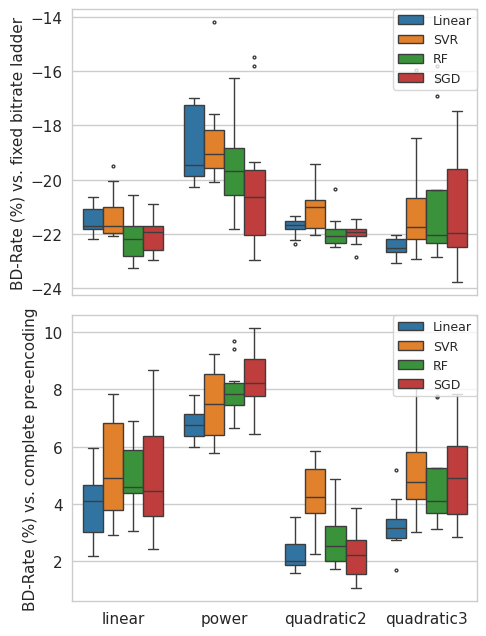

In [18]:
# 直观看一下区别: 总的来说还是 quadratic2 最好，然后 regressor 最好用 linear regression 和 random forest (SGD 也还行)
label_mapping = {
    'Adam': 'Adam',
    'LinearRegression': 'Linear',
    'LinearSVR': 'SVR',
    'RMSProp': 'RMSProp',
    'RandomForestRegressor': 'RF',
    'SGDRegressor': 'SGD'
}

# 1. 先画一下 BD-Rate (左边是相比 fixed QP 的, 右边是相比 traditional CAE 的)
fig, axes = plt.subplots(2, 1, figsize=(5, 6.5), sharex=True)

sns.boxplot(ax=axes[0], data=avg_bdbr[(avg_bdbr["anchor"] == "fixed") & (avg_bdbr["regressor"] != "Adam") & (avg_bdbr["regressor"] != "RMSProp")], x="func", y="bd_rate", hue="regressor", flierprops=flierprops)
handles, labels = axes[0].get_legend_handles_labels()
new_labels = [label_mapping[label] for label in labels]
axes[0].set_xlabel("")
axes[0].set_ylabel("BD-Rate (%) vs. fixed bitrate ladder")
axes[0].legend(handles, new_labels, borderaxespad=0., loc="upper right")

sns.boxplot(ax=axes[1], data=avg_bdbr[(avg_bdbr["anchor"] == "cae") & (avg_bdbr["regressor"] != "Adam") & (avg_bdbr["regressor"] != "RMSProp")], x="func", y="bd_rate", hue="regressor", flierprops=flierprops)
handles, labels = axes[1].get_legend_handles_labels()
new_labels = [label_mapping[label] for label in labels]
axes[1].set_xlabel("")
axes[1].set_ylabel("BD-Rate (%) vs. complete pre-encoding")
axes[1].legend(handles, new_labels, borderaxespad=0., loc="upper right")

fig_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"
plt.tight_layout()
plt.savefig(f"{fig_dir}/BDBR/bd_rate_log2psnr.pdf", format="pdf")

<Figure size 700x500 with 0 Axes>

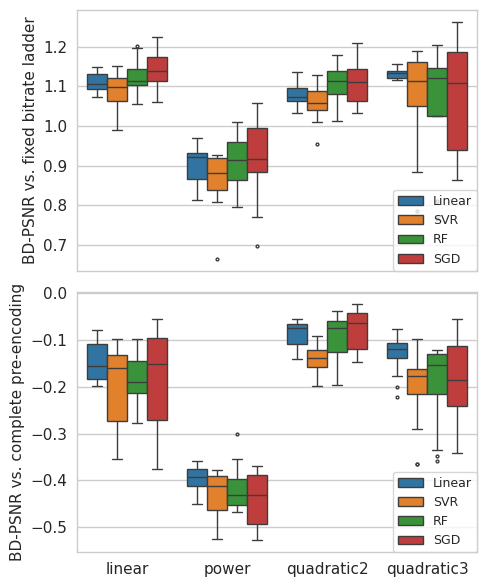

In [19]:
# 直观看一下区别: 总的来说还是 quadratic2 最好，然后 regressor 最好用 linear regression 和 random forest (SGD 也还行)

# 2. 再画一下 BD-Rate (左边是相比 fixed QP 的, 右边是相比 traditional CAE 的)
fig, axes = plt.subplots(2, 1, figsize=(5, 6), sharex=True)

sns.boxplot(ax=axes[0], data=avg_bdbr[(avg_bdbr["anchor"] == "fixed") & (avg_bdbr["regressor"] != "Adam") & (avg_bdbr["regressor"] != "RMSProp")], x="func", y="bd_psnr", hue="regressor", flierprops=flierprops)
handles, labels = axes[0].get_legend_handles_labels()
new_labels = [label_mapping[label] for label in labels]
axes[0].set_xlabel("")
axes[0].set_ylabel("BD-PSNR vs. fixed bitrate ladder")
axes[0].legend(handles, new_labels, borderaxespad=0., loc="lower right")

sns.boxplot(ax=axes[1], data=avg_bdbr[(avg_bdbr["anchor"] == "cae") & (avg_bdbr["regressor"] != "Adam") & (avg_bdbr["regressor"] != "RMSProp")], x="func", y="bd_psnr", hue="regressor", flierprops=flierprops)
handles, labels = axes[1].get_legend_handles_labels()
new_labels = [label_mapping[label] for label in labels]
axes[1].set_xlabel("")
axes[1].set_ylabel("BD-PSNR vs. complete pre-encoding")
axes[1].legend(handles, new_labels, borderaxespad=0., loc="lower right")

fig_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"
plt.tight_layout()
plt.savefig(f"{fig_dir}/BDBR/bd_psnr_log2psnr.pdf", format="pdf")

#### 2. 预测的是 psnr

In [ ]:
import pandas as pd

pred_df = pd.read_csv(f"{table_dir}/predCurve/combined_preds.csv")
pred_df = pred_df.drop(columns=["p1", "p2", "p3", "pred_p1", "pred_p2", "pred_p3"])     # 不用看参数了

display(pred_df)
print(pred_df.columns.tolist())

In [6]:
""" 计算所有序列的 RD 性能 """
grouped = pred_df.groupby(["seqName", "sceneId", "preset"], as_index=False)

from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

tasks = []
verbose = True
for (seqName, sceneId, preset), group in tqdm(grouped):
    for regressor in group["regressor"].unique():
        for func in group["func"].unique():
            for inputs in group["input"].unique():
                tasks.append((seqName, sceneId, preset, group, regressor, inputs, func, "psnr"))
                verbose = False

with ProcessPoolExecutor() as executor:
    executor.map(process_group, tasks)

100%|██████████| 66/66 [00:05<00:00, 11.58it/s]


In [7]:
""" 把每个序列所有的 dataframe 叠在一起 """
import pandas as pd
from tqdm import tqdm

seqs = os.listdir(f"{table_dir}/BDBR/rd-psnr")
convex_df = pd.DataFrame()

for seq in seqs:
    for f in tqdm(os.listdir(f"{table_dir}/BDBR/rd-psnr/{seq}")):
        convex_df = pd.concat([convex_df, pd.read_csv(f"{table_dir}/BDBR/rd-psnr/{seq}/{f}")], axis=0)

convex_df = convex_df.reset_index(drop=True) 
display(convex_df)

convex_df.to_csv(f"{table_dir}/BDBR/convex_psnr.csv", index=False)

100%|██████████| 864/864 [00:57<00:00, 14.99it/s]


,seqName,sceneId,regressor,func,input,preset,size,qp,pred_psnr,log2psnr,psnr,pred_log2bitrate,log2bitrate,bitrate,pred_bitrate,convex
0,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,360P,52,36.226711,5.141633,35.300897,3.682048,4.471851,22.1902,12.835327,pred
1,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,540P,52,35.241048,5.184935,36.376495,3.880789,4.886233,29.5735,14.731057,pred
2,Lecture-5f3a,0,LinearRegression,power,(medium)x(360P),faster,1080P,22,58.200520,5.664675,50.726739,12.506482,12.602524,6219.2459,5818.701542,pred
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417474,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,360P,27,41.623115,5.385711,41.808125,9.196966,9.594119,772.8900,586.898086,fixed
417475,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,540P,27,43.676483,5.452756,43.796875,10.404303,10.338697,1294.9650,1355.211758,fixed
417476,Lecture-6d29,3,LinearRegression,linear,(medium)x(540P),slower,720P,27,44.734493,5.494676,45.088125,11.381953,10.785714,1765.3200,2668.758535,fixed


In [12]:
""" 计算 BDBR -> 1) 相较于传统 CAE (会有 loss);  2) 相较于 fixed QP (会有 gain) """
import sys
sys.path.append("../")

from metrics.bjontegaard import BD_PSNR, BD_RATE
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 8)

grouped = convex_df.groupby(["seqName", "sceneId", "regressor", "func", "input", "preset"])
rows = []
for i, ((seqName, sceneId, regressor, func, inputs, preset), group) in tqdm(enumerate(grouped)):
    pred_convex_df   = group[group["convex"] == "pred"].sort_values(by="bitrate").reset_index(drop=True)
    actual_convex_df = group[group["convex"] == "actual"].sort_values(by="bitrate").reset_index(drop=True)
    fixed_convex_df  = group[group["convex"] == "fixed"].sort_values(by="bitrate").reset_index(drop=True)
    
    bd_rate_cae = BD_RATE(
        actual_convex_df["bitrate"].tolist(), actual_convex_df["psnr"].tolist(), 
        pred_convex_df["bitrate"].tolist(), pred_convex_df["psnr"].tolist(), piecewise=0
    )
    bd_psnr_cae = BD_PSNR(
        actual_convex_df["bitrate"].tolist(), actual_convex_df["psnr"].tolist(), 
        pred_convex_df["bitrate"].tolist(), pred_convex_df["psnr"].tolist(), piecewise=0
    )
    
    bd_rate_fix = BD_RATE(
        fixed_convex_df["bitrate"].tolist(), fixed_convex_df["psnr"].tolist(), 
        pred_convex_df["bitrate"].tolist(), pred_convex_df["psnr"].tolist(), piecewise=0
    )
    bd_psnr_fix = BD_PSNR(
        fixed_convex_df["bitrate"].tolist(), fixed_convex_df["psnr"].tolist(), 
        pred_convex_df["bitrate"].tolist(), pred_convex_df["psnr"].tolist(), piecewise=0
    )
    rows.append([seqName, sceneId, regressor, func, inputs, preset, bd_rate_cae, bd_psnr_cae, "cae"])
    rows.append([seqName, sceneId, regressor, func, inputs, preset, bd_rate_fix, bd_psnr_fix, "fixed"])
    
all_bdbr = pd.DataFrame(rows, columns=["seqName", "sceneId", "regressor", "func", "input", "preset", "bd_rate", "bd_psnr", "anchor"])
all_bdbr = rm_outliers(all_bdbr, cols=["bd_psnr", "bd_rate"], threshold=0.75)
display(all_bdbr)
display(all_bdbr.describe())                  

all_bdbr.to_csv(f"{table_dir}/BDBR/all_rd_psnr.csv", index=False)

0it [00:00, ?it/s]

19008it [00:48, 392.99it/s]


,seqName,sceneId,regressor,func,input,preset,bd_rate,bd_psnr,anchor
0,Lecture-42c3,0,Adam,linear,(faster)x(1080P),faster,7.419363,-0.701158,cae
1,Lecture-42c3,0,Adam,linear,(faster)x(1080P),faster,-29.132545,1.776980,fixed
2,Lecture-42c3,0,Adam,linear,(faster)x(1080P),medium,-0.167622,0.054654,cae
3,Lecture-42c3,0,Adam,linear,(faster)x(1080P),medium,-26.883036,1.809351,fixed
...,...,...,...,...,...,...,...,...,...
38012,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),medium,17.174460,-0.659810,cae
38013,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),medium,-30.130470,1.588775,fixed
38014,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),slower,18.673430,-0.494465,cae
38015,Lecture-7e40,1,SGDRegressor,quadratic3,(slower)x(720P),slower,-32.284099,2.121644,fixed


,sceneId,bd_rate,bd_psnr
count,36239.000000,36239.000000,36239.000000
mean,3.513204,-6.575091,0.317414
std,3.511248,15.876525,0.782440
min,0.000000,-39.859459,-1.226421
25%,1.000000,-20.328025,-0.276794
50%,2.000000,-0.375081,0.040459
75%,6.000000,5.036390,0.893503
max,11.000000,97.807338,3.765763


In [13]:
# 看一下不同预测策略 (regressor, func, input) 的效果
table_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/tables"
all_bdbr = pd.read_csv(f"{table_dir}/BDBR/all_rd_log2psnr.csv")

grouped = all_bdbr.groupby(["anchor", "regressor", "func", "input"], as_index=False)

rows = []
for (anchor, regressor, func, inputs), group in grouped:
    group = group.reset_index(drop=True)
    rows.append([regressor, func, inputs, group["bd_rate"].mean(), group["bd_psnr"].mean(), anchor])

avg_bdbr = pd.DataFrame(rows, columns=["regressor", "func", "input", "bd_rate", "bd_psnr", "anchor"])
avg_bdbr = rm_outliers(avg_bdbr, cols=["bd_rate", "bd_psnr"], threshold=1.25).reset_index(drop=True)
display(avg_bdbr)

avg_bdbr.to_csv(f"{table_dir}/BDBR/avg_rd_psnr.csv", index=False)

,regressor,func,input,bd_rate,bd_psnr,anchor
0,Adam,linear,(faster)x(1080P),7.516423,-0.342235,cae
1,Adam,linear,(faster)x(360P),7.495171,-0.366731,cae
2,Adam,linear,(faster)x(540P),6.348734,-0.234371,cae
3,Adam,linear,(faster)x(720P),6.929901,-0.324279,cae
...,...,...,...,...,...,...
572,SGDRegressor,quadratic3,(slower)x(1080P),-20.590605,1.080289,fix
573,SGDRegressor,quadratic3,(slower)x(360P),-19.770010,0.951263,fix
574,SGDRegressor,quadratic3,(slower)x(540P),-22.163321,1.110005,fix
575,SGDRegressor,quadratic3,(slower)x(720P),-22.425029,1.181384,fix


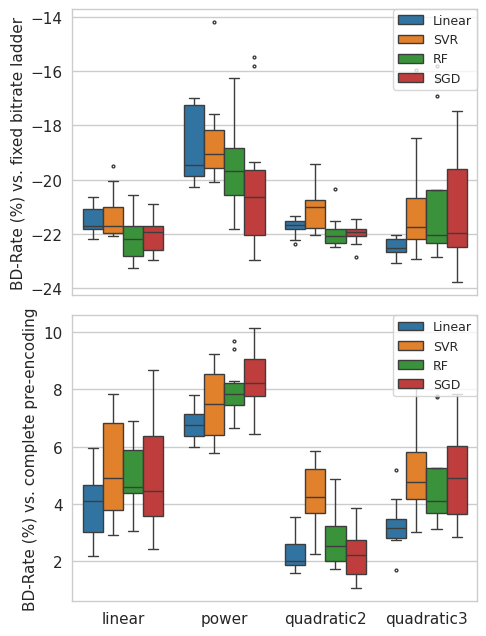

In [15]:
# 直观看一下区别: 总的来说还是 quadratic2 最好，然后 regressor 最好用 linear regression 和 random forest (SGD 也还行)
label_mapping = {
    'Adam': 'Adam',
    'LinearRegression': 'Linear',
    'LinearSVR': 'SVR',
    'RMSProp': 'RMSProp',
    'RandomForestRegressor': 'RF',
    'SGDRegressor': 'SGD'
}

# 1. 先画一下 BD-Rate (左边是相比 fixed QP 的, 右边是相比 traditional CAE 的)
fig, axes = plt.subplots(2, 1, figsize=(5, 6.5), sharex=True)

sns.boxplot(ax=axes[0], data=avg_bdbr[(avg_bdbr["anchor"] == "fix") & (avg_bdbr["regressor"] != "Adam") & (avg_bdbr["regressor"] != "RMSProp")], x="func", y="bd_rate", hue="regressor", flierprops=flierprops)
handles, labels = axes[0].get_legend_handles_labels()
new_labels = [label_mapping[label] for label in labels]
axes[0].set_xlabel("")
axes[0].set_ylabel("BD-Rate (%) vs. fixed bitrate ladder")
axes[0].legend(handles, new_labels, borderaxespad=0., loc="upper right")

sns.boxplot(ax=axes[1], data=avg_bdbr[(avg_bdbr["anchor"] == "cae") & (avg_bdbr["regressor"] != "Adam") & (avg_bdbr["regressor"] != "RMSProp")], x="func", y="bd_rate", hue="regressor", flierprops=flierprops)
handles, labels = axes[1].get_legend_handles_labels()
new_labels = [label_mapping[label] for label in labels]
axes[1].set_xlabel("")
axes[1].set_ylabel("BD-Rate (%) vs. complete pre-encoding")
axes[1].legend(handles, new_labels, borderaxespad=0., loc="upper right")

fig_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"
plt.tight_layout()
plt.savefig(f"{fig_dir}/BDBR/bd_rate_psnr.pdf", format="pdf")

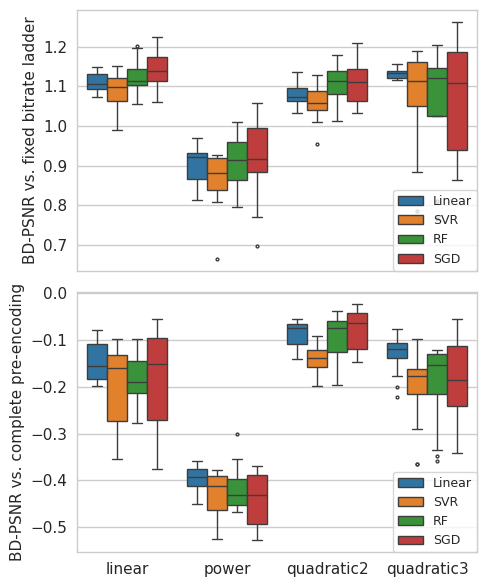

In [16]:
# 直观看一下区别: 总的来说还是 quadratic2 最好，然后 regressor 最好用 linear regression 和 random forest (SGD 也还行)

# 2. 再画一下 BD-Rate (左边是相比 fixed QP 的, 右边是相比 traditional CAE 的)
fig, axes = plt.subplots(2, 1, figsize=(5, 6), sharex=True)

sns.boxplot(ax=axes[0], data=avg_bdbr[(avg_bdbr["anchor"] == "fix") & (avg_bdbr["regressor"] != "Adam") & (avg_bdbr["regressor"] != "RMSProp")], x="func", y="bd_psnr", hue="regressor", flierprops=flierprops)
handles, labels = axes[0].get_legend_handles_labels()
new_labels = [label_mapping[label] for label in labels]
axes[0].set_xlabel("")
axes[0].set_ylabel("BD-PSNR vs. fixed bitrate ladder")
axes[0].legend(handles, new_labels, borderaxespad=0., loc="lower right")

sns.boxplot(ax=axes[1], data=avg_bdbr[(avg_bdbr["anchor"] == "cae") & (avg_bdbr["regressor"] != "Adam") & (avg_bdbr["regressor"] != "RMSProp")], x="func", y="bd_psnr", hue="regressor", flierprops=flierprops)
handles, labels = axes[1].get_legend_handles_labels()
new_labels = [label_mapping[label] for label in labels]
axes[1].set_xlabel("")
axes[1].set_ylabel("BD-PSNR vs. complete pre-encoding")
axes[1].legend(handles, new_labels, borderaxespad=0., loc="lower right")

fig_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"
plt.tight_layout()
plt.savefig(f"{fig_dir}/BDBR/bd_psnr_psnr.pdf", format="pdf")